In [ ]:

import subprocess
import sys
import os

 
 

# Get the parent directory path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add the parent directory to sys.path
sys.path.insert(0, parent_dir)
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

 
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "numpy", "torch"])
 
#install("pandas")
#install("scikit-learn")
#install("matplotlib")
#install("xgboost")
#install("statsmodels")
#install("cvxpy")
#install("Mapie")

  Using cached numpy-2.1.1-cp312-cp312-macosx_14_0_x86_64.whl.metadata (60 kB)
Using cached numpy-2.1.1-cp312-cp312-macosx_14_0_x86_64.whl (6.6 MB)


In [4]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
import os 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import random
from SelfCalibratingConformal.SelfCalibratingConformalPredictor import *
from data_analysis_utils import *
from competitors import *
from condconf import *


from datasets.datasets import GetDataset


def prepare_data(data_name, base_path, random_state=3, p_train=0.5, p_cal=0.3, log_transform_y = False):
    """
    Load data, preprocess features, and split into train, calibration, and test sets.

    Parameters:
    - filepath (str): Path to the CSV file containing the data.
    - random_state (int): Seed used by the random number generator for reproducibility.
    - p_train (float): Proportion of data to be used for training.
    - p_cal (float): Proportion of data to be used for calibration.
    - p_test (float): Proportion of data to be used for testing.
    - response_column (str): Name of the column to be used as the response variable.

    Returns:
    - X_train (np.ndarray): Features for the training set.
    - y_train (np.ndarray): Response for the training set.
    - X_cal (np.ndarray): Features for the calibration set.
    - y_cal (np.ndarray): Response for the calibration set.
    - X_test (np.ndarray): Features for the test set.
    - y_test (np.ndarray): Response for the test set.
    """

    p_test= 1 - p_train -p_cal
    # Load data
    X,y = GetDataset(data_name , base_path)
    y = np.array(y).reshape(-1)


    if log_transform_y:
      y = np.log(1 + y)

    # Split data into train, calibration, and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - p_train, random_state=random_state)
    X_cal, X_test, y_cal, y_test = train_test_split(X_test, y_test, test_size=p_test / (p_cal + p_test), random_state=random_state)

    return X_train, y_train, X_cal, y_cal, X_test, y_test

import lightgbm as lgb
from mapie.regression import MapieQuantileRegressor

def CQR(X_train, y_train, X_cal, y_cal, X_test, alpha=0.1):
    # Define the LightGBM model for quantile regression
    params_lgb = {
        "objective": "quantile",
        "alpha": 0.5,  # Default median, we'll adjust for lower and upper quantiles
        "n_estimators": 100,
        "min_data_in_leaf": 30,
        "max_depth": 9,
        "learning_rate": 0.1,
        "num_leaves": 31,
        "boosting_type": "gbdt",
        "random_state": 42,
        'verbose': -1
    }

    # Set up the MapieQuantileRegressor
    mapie_regressor = MapieQuantileRegressor(
        estimator=lgb.LGBMRegressor(**params_lgb),
        alpha=alpha
    )

    # Fit the model on the training data
    mapie_regressor.fit(X_train, y_train)

    # Predict the intervals on the test data
    y_pred_test, y_pis_test = mapie_regressor.predict(X_test)
    y_median = y_pred_test
    y_lower = y_pis_test[:, 0]
    y_upper = y_pis_test[:, 1]

    return y_median, np.hstack([y_lower, y_upper])



def run_regression_analysis(data_name, base_path, random_state=10, poor_calibration=False, cross_validate_xgb=False,
                            p_train_nonwhite=None, test_subset_nonwhite=False, p_train=0.5, p_cal=0.3):

    # Import external utilities (make sure this module is available in your path)

    # Data transformation based on calibration setting
    if poor_calibration:
        transform = lambda y: np.log(1 + np.maximum(y, 0))
    else:
        transform = lambda x: x

    X_train, y_train, X_cal, y_cal, X_test, y_test = prepare_data(data_name, 
                                                                  base_path,
        random_state=random_state,
        p_train=p_train, p_cal=p_cal,
        log_transform_y=not poor_calibration)
    model = train_xgb_model(X_train, y_train, cross_validate=cross_validate_xgb)

    y_train = transform(y_train)
    y_cal = transform(y_cal)
    y_test = transform(y_test)

     

    

    def predictor(x):
        return transform(model.predict(x))

    y_hat =  predictor(X_test)

    # CQR baseline
    y_hat_median, intervals_cqr = CQR(X_train, y_train, X_cal, y_cal, X_test, alpha=0.1)
    intervals_cqr[:,0] = np.maximum(0, intervals_cqr[:,0])
    
    # Fit a GAM for the left interval
    from sklearn.ensemble import RandomForestRegressor
    rf_regressor = RandomForestRegressor(n_estimators=1000, max_depth = 6, random_state=42)

    # Fit the random forest to the lower interval without sorting
    rf_regressor.fit(y_hat.reshape(-1, 1), intervals_cqr[:, 0])
    left_smoothed = rf_regressor.predict(y_hat.reshape(-1, 1))

    # Fit the random forest to the upper interval without sorting
    rf_regressor.fit(y_hat.reshape(-1, 1), intervals_cqr[:, 1])
    right_smoothed = rf_regressor.predict(y_hat.reshape(-1, 1))

    # Combine smoothed intervals
    intervals_cqr_smooth = np.vstack([left_smoothed, right_smoothed]).T
     


    # Compute intervals using SC-CP
    cp_sc = SelfCalibratingConformalPredictor(predictor, calibrator_params={'max_depth': 15, 'min_child_weight': 30})
    cp_sc.calibrate(X_cal, y_cal, scoring_method="calibrated", hist_shrinkage_num_bin=100)
    y_hat_sc = cp_sc.predict_point(X_test)
    y_hat_venn_abers = cp_sc.predict_venn_abers(X_test)
    intervals_sc = cp_sc.predict_interval(X_test)
    
    # Conditional CP using kernel smoothing
    print("Kernel")
    cp_kernel = kernelCP(predictor, num_bin_predictor= 30)
    cp_kernel.calibrate(X_cal[1:500, :], y_cal[1:500], lambd = 0.005)
    intervals_kernel = cp_kernel.predict_interval(X_test)
    print("End Kernel")
    
    # Compute unconditional CP
    cp_uncond = MondrianCP(predictor, num_bins=1)
    cp_uncond.calibrate(X_cal, y_cal)
    intervals_uncond = cp_uncond.predict_interval(X_test)

    # Compute intervals using Mondrian CP with quantile binning of predictions
    ## 5 bins
    cp_mondrian_5 = MondrianCP(predictor, num_bins=5)
    cp_mondrian_5.calibrate(X_cal, y_cal)
    intervals_mondrian_5 = cp_mondrian_5.predict_interval(X_test)
    ## 10 bins
    cp_mondrian_10 = MondrianCP(predictor, num_bins=10)
    cp_mondrian_10.calibrate(X_cal, y_cal)
    intervals_mondrian_10 = cp_mondrian_10.predict_interval(X_test)
    ## Data-dependent bins being same number of bins in isotonic calibration solution in SC-CP
    cp_mondrian_opt = MondrianCP(predictor, num_bins=len(set(y_hat_sc)))
    cp_mondrian_opt.calibrate(X_cal, y_cal)
    intervals_mondrian_opt = cp_mondrian_opt.predict_interval(X_test)


    plot_comparison = plot_prediction_intervals_baseline_grid(y_hat, y_test, y_hat_sc, 
            dict_of_intervals = {
            #"SC-CP": intervals_sc,
            "Marginal": intervals_uncond,
            "CQR (marginal)": intervals_cqr_smooth,
            #"Mondrian (5 bins)": intervals_mondrian_5,
            "Mondrian (10 bins)": intervals_mondrian_10,
            "Kernel": intervals_kernel
          })
     
    

    #return cp_sc.plot(X_test, y_test), plot_comparison, cp_sc
    
    results = {
        "Method": [],
        "Coverage_0": [],
        "Coverage_1": [],
        "Average Width_0": [],
        "Average Width_1": [],
        "cal_error_0": [],
        "cal_error_1": []
    }
    names = ["Marginal", "CQR (marginal)", "Mondrian (5 bins)", "Mondrian (10 bins)", f"Mondrian ({len(set(y_hat_sc))} bins)", "Kernel", "SC-CP"]
    methods = [intervals_uncond, intervals_cqr, intervals_mondrian_5, intervals_mondrian_10, intervals_mondrian_opt, intervals_kernel, intervals_sc]

    for method, name in zip(methods, names):
        binary_var = X_test[:, -1]
        if not np.all(np.isin(binary_var, [0, 1])):
            binary_var = 1*(binary_var >= np.median(binary_var))
        coverage_data = calculate_coverage_in_bins(binary_var, method, y_test)
        subgroup_indicator = [x[0] for x in coverage_data]
        coverage_0 = [x[2] for i, x in enumerate(coverage_data) if subgroup_indicator[i] == 0]
        coverage_1 = [x[2] for i, x in enumerate(coverage_data) if subgroup_indicator[i] == 1]
        width_0 = [x[1] for i, x in enumerate(coverage_data) if subgroup_indicator[i] == 0]
        width_1 = [x[1] for i, x in enumerate(coverage_data) if subgroup_indicator[i] == 1]

        if name == "SC-CP":
          cal_error_0 = np.mean((y_hat_sc - y_test)[binary_var == 0])
          cal_error_1 = np.mean((y_hat_sc - y_test)[binary_var == 1])
        elif name == "CQR (marginal)":
            cal_error_0 = np.mean((y_hat_median - y_test)[binary_var == 0])
            cal_error_1 = np.mean((y_hat_median - y_test)[binary_var == 1])
        else:
          cal_error_0 = np.mean((y_hat - y_test)[binary_var == 0])
          cal_error_1 = np.mean((y_hat - y_test)[binary_var == 1])
        results["Method"].append(name)
        results["Coverage_0"].append(np.mean(coverage_0))
        results["Coverage_1"].append(np.mean(coverage_1))
        results["Average Width_0"].append(np.mean(width_0))
        results["Average Width_1"].append(np.mean(width_1))
        results["cal_error_0"].append(np.mean(cal_error_0))
        results["cal_error_1"].append(np.mean(cal_error_1))

    df = pd.DataFrame(results)
    df = df.map(lambda x: float(f"{x:.3g}") if isinstance(x, (int, float)) else x)
    df = df.map(lambda x: f'{x:g}' if isinstance(x, (int, float)) else x)

    # Output the table in LaTeX format
     
    #print(df.to_latex(index=False))

    
    return df, cp_sc.plot(X_test, y_test), plot_comparison, cp_sc

ModuleNotFoundError: No module named 'SelfCalibratingConformal'

In [ ]:
import random
random.seed(12345)

poor_calibration = True
for data_name in ['bike', 'bio', 'star', 'meps_21', 'concrete', 'community']:
    path = "datasets/"
    df, plot, plot_comp, obj = run_regression_analysis(data_name, path, poor_calibration = poor_calibration, cross_validate_xgb = True)
    df_table = pd.DataFrame(df)
    

    # Rename the columns
    df_table.columns = [
    'Method',
    'Coverage (A=0)',
    'Coverage (A=1)',
    'Average Width (A=0)',
    'Average Width (A=1)',
    'Cal. Error (A=0)',
    'Cal. Error (A=1)'
    ]
    print(df_table)

    # Convert DataFrame to LaTeX table
    latex_table = df_table.to_latex(index=False)
    with open(f"latex_table_{data_name}_{poor_calibration}.txt", "w") as file:
        file.write(latex_table)
    
    plot[0].savefig(f'plot_SCCP_{data_name}_{poor_calibration}.pdf', format='pdf', dpi=300)
    #plot_comp[0].text(0.5, 0.02, 'Original Prediction (uncalibrated)', ha='center', fontsize=20)
    plot_comp[0].savefig(f'plot_compare_{data_name}_{poor_calibration}.pdf', format='pdf', dpi=300)


In [2]:
import random
random.seed(12345)
poor_calibration = False
for data_name in ['bike', 'bio', 'star', 'meps_21', 'concrete', 'community']:
    path = "datasets/"
    df, plot, plot_comp, obj = run_regression_analysis(data_name, path, poor_calibration = poor_calibration, cross_validate_xgb = True)
    df_table = pd.DataFrame(df)

    # Rename the columns
    df_table.columns = [
    'Method',
    'Coverage (A=0)',
    'Coverage (A=1)',
    'Average Width (A=0)',
    'Average Width (A=1)',
    'Cal. Error (A=0)',
    'Cal. Error (A=1)'
    ]

    # Convert DataFrame to LaTeX table
    latex_table = df_table.to_latex(index=False)
    with open(f"latex_table_{data_name}_{poor_calibration}.txt", "w") as file:
        file.write(latex_table)
    
    plot[0].savefig(f'plot_SCCP_{data_name}_{poor_calibration}.pdf', format='pdf', dpi=300)
    #plot_comp[0].text(0.5, 0.02, 'Original Prediction (uncalibrated)', ha='center', fontsize=20)
    plot_comp[0].savefig(f'plot_compare_{data_name}_{poor_calibration}.pdf', format='pdf', dpi=300)


NameError: name 'run_regression_analysis' is not defined

# Old

In [11]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
import os 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import random
from SelfCalibratingConformal.SelfCalibratingConformalPredictor import *
from data_analysis.data_analysis_utils import *
from data_analysis.competitors import *
from data_analysis.condconf import *


from datasets.datasets import GetDataset


def prepare_data(data_name, base_path, random_state=3, p_train=0.5, p_cal=0.3, log_transform_y = False):
    """
    Load data, preprocess features, and split into train, calibration, and test sets.

    Parameters:
    - filepath (str): Path to the CSV file containing the data.
    - random_state (int): Seed used by the random number generator for reproducibility.
    - p_train (float): Proportion of data to be used for training.
    - p_cal (float): Proportion of data to be used for calibration.
    - p_test (float): Proportion of data to be used for testing.
    - response_column (str): Name of the column to be used as the response variable.

    Returns:
    - X_train (np.ndarray): Features for the training set.
    - y_train (np.ndarray): Response for the training set.
    - X_cal (np.ndarray): Features for the calibration set.
    - y_cal (np.ndarray): Response for the calibration set.
    - X_test (np.ndarray): Features for the test set.
    - y_test (np.ndarray): Response for the test set.
    """

    p_test= 1 - p_train -p_cal
    # Load data
    X,y = GetDataset(data_name , base_path)


    if log_transform_y:
      y = np.log(1 + y)

    # Split data into train, calibration, and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - p_train, random_state=random_state)
    X_cal, X_test, y_cal, y_test = train_test_split(X_test, y_test, test_size=p_test / (p_cal + p_test), random_state=random_state)

    return X_train, y_train, X_cal, y_cal, X_test, y_test
def run_regression_analysis_meps(base_path, random_state=10, poor_calibration=False, cross_validate_xgb=False, p_train=0.5, p_cal=0.3):

    # Import external utilities (make sure this module is available in your path)

    # Data transformation based on calibration setting
    if poor_calibration:
        transform = lambda y: np.log(1 + np.maximum(y, 0))
    else:
        transform = lambda x: x

    X_train, y_train, _, _, _, _ = prepare_data("meps_19", 
                                                                  base_path,
        random_state=random_state,
        p_train=0.99, p_cal=0.005,
        log_transform_y=not poor_calibration)

    
    _, _, X_cal, y_cal, X_test, y_test = prepare_data("meps_21", 
                                                                  base_path,
        random_state=random_state,
        p_train=0.01, p_cal=0.5,
        log_transform_y=not poor_calibration)
    model = train_xgb_model(X_train, y_train, cross_validate=cross_validate_xgb)

    y_train = transform(y_train)
    y_cal = transform(y_cal)
    y_test = transform(y_test)


    def predictor(x):
        return transform(model.predict(x))

    y_hat = predictor(X_test)

    # Compute intervals using SC-CP
    cp_sc = SelfCalibratingConformalPredictor(predictor, calibrator_params={'max_depth': 15, 'min_child_weight': 20})
    cp_sc.calibrate(X_cal, y_cal, scoring_method="calibrated", hist_shrinkage_num_bin=10)
    y_hat_sc = cp_sc.predict_point(X_test)
    y_hat_venn_abers = cp_sc.predict_venn_abers(X_test)
    intervals_sc = cp_sc.predict_interval(X_test)
    
    # Conditional CP using kernel smoothing
    print("Kernel")
    cp_kernel = kernelCP(predictor, num_bin_predictor= 30)
    cp_kernel.calibrate(X_cal[1:250, :], y_cal[1:250], lambd = 0.005)
    intervals_kernel = cp_kernel.predict_interval(X_test)
    print("End Kernel")
    
    # Compute unconditional CP
    cp_uncond = MondrianCP(predictor, num_bins=1)
    cp_uncond.calibrate(X_cal, y_cal)
    intervals_uncond = cp_uncond.predict_interval(X_test)

    # Compute intervals using Mondrian CP with quantile binning of predictions
    ## 5 bins
    cp_mondrian_5 = MondrianCP(predictor, num_bins=5)
    cp_mondrian_5.calibrate(X_cal, y_cal)
    intervals_mondrian_5 = cp_mondrian_5.predict_interval(X_test)
    ## 10 bins
    cp_mondrian_10 = MondrianCP(predictor, num_bins=10)
    cp_mondrian_10.calibrate(X_cal, y_cal)
    intervals_mondrian_10 = cp_mondrian_10.predict_interval(X_test)
    ## Data-dependent bins being same number of bins in isotonic calibration solution in SC-CP
    cp_mondrian_opt = MondrianCP(predictor, num_bins=len(set(y_hat_sc)))
    cp_mondrian_opt.calibrate(X_cal, y_cal)
    intervals_mondrian_opt = cp_mondrian_opt.predict_interval(X_test)


    plot_comparison = plot_prediction_intervals_baseline_grid(y_hat, y_test, y_hat_sc, 
            dict_of_intervals = {
            "SC-CP": intervals_sc,
            "Marginal": intervals_uncond,
            "Mondrian (10 bins)": intervals_mondrian_10,
            "Kernel": intervals_kernel
          })
     
    

    return cp_sc.plot(X_test, y_test), plot_comparison, cp_sc
    
    results = {
        "Method": [],
        "Coverage_0": [],
        "Coverage_1": [],
        "Average Width_0": [],
        "Average Width_1": [],
        "cal_error_0": [],
        "cal_error_1": []
    }
    names = ["Marginal", "Mondrian (5 bins)", "Mondrian (10 bins)", f"Mondrian ({len(set(y_hat_sc))} bins)", "Kernel", "SC-CP"]
    methods = [intervals_uncond, intervals_mondrian_5, intervals_mondrian_10, intervals_mondrian_opt, intervals_kernel, intervals_sc]

    for method, name in zip(methods, names):
        sub_ind = np.ones_like(y_test) # X_test[:, -1]
        coverage_data = calculate_coverage_in_bins(sub_ind, method, y_test)
        subgroup_indicator = [x[0] for x in coverage_data]
        coverage_0 = [x[2] for i, x in enumerate(coverage_data) if subgroup_indicator[i] == 0]
        coverage_1 = [x[2] for i, x in enumerate(coverage_data) if subgroup_indicator[i] == 1]
        width_0 = [x[1] for i, x in enumerate(coverage_data) if subgroup_indicator[i] == 0]
        width_1 = [x[1] for i, x in enumerate(coverage_data) if subgroup_indicator[i] == 1]

        if name == "SC-CP":
          cal_error_0 = np.mean((y_hat_sc - y_test)[X_test[:, -1] == 0] > 0)
          cal_error_1 = np.mean((y_hat_sc - y_test)[X_test[:, -1] == 1] > 0)
        else:
          cal_error_0 = np.mean((y_hat - y_test)[X_test[:, -1] == 0] > 0)
          cal_error_1 = np.mean((y_hat - y_test)[X_test[:, -1] == 1] > 0)
        results["Method"].append(name)
        results["Coverage_0"].append(np.mean(coverage_0))
        results["Coverage_1"].append(np.mean(coverage_1))
        results["Average Width_0"].append(np.mean(width_0))
        results["Average Width_1"].append(np.mean(width_1))
        results["cal_error_0"].append(np.mean(cal_error_0))
        results["cal_error_1"].append(np.mean(cal_error_1))

    df = pd.DataFrame(results)
    df = df.map(lambda x: float(f"{x:.3g}") if isinstance(x, (int, float)) else x)
    df = df.map(lambda x: f'{x:g}' if isinstance(x, (int, float)) else x)

    # Output the table in LaTeX format
     
    #print(df.to_latex(index=False))

    
    return df, cp_sc.plot(X_test, y_test), plot_comparison, cp_sc




Best parameters: {'learning_rate': 0.02, 'max_depth': 6, 'n_estimators': 200}
Kernel
0.005
End Kernel


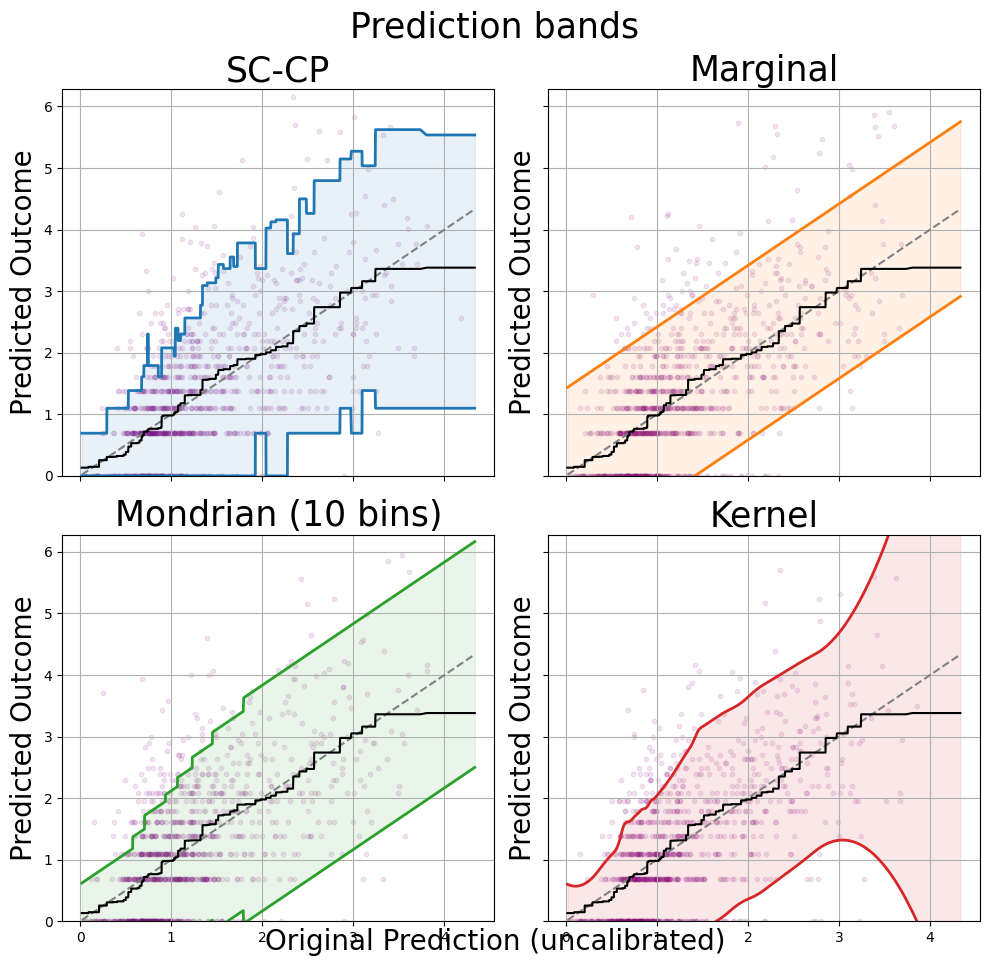

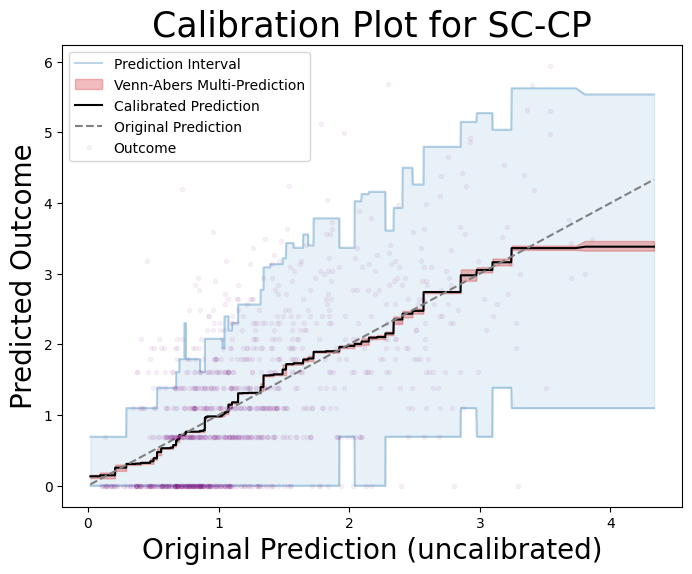

In [12]:
path = "datasets/"
plot, plot_comp, obj = run_regression_analysis_meps(base_path = path, cross_validate_xgb = True)